# Section 1 of Toy Models of Superposition

In [1]:
import os
import torch
import random
from torch import nn
# from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms

In [2]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using mps device


## Defining Model

In [3]:
class ToyModelNoSparsity(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(2, 5), requires_grad=True)
        self.bias = nn.Parameter(torch.rand(5, 1), requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        
    def forward(self, x): # x is 5 * 1
        hidden = self.weights @ x
        final = self.weights.T @ hidden
        final += self.bias
        return self.ReLU(final)

class ImporanceWeightedMSE(nn.Module):
    def __init__(self):
        super(ImporanceWeightedMSE, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0).flatten()
        return sum(sub_total * importance)

In [4]:
NUM_EPOCHS = 10
BATCHS_PER_EPOCH = 1000
BATCH_SIZE = 50


def train(model, loss_fn, optimizer, importance, sparsity):
    probability = 1 - sparsity
    model.train()
    loss_total = 0
    for epoch in range(NUM_EPOCHS):
        for i in range(BATCHS_PER_EPOCH):
            sparsity_tensor = torch.bernoulli(torch.full((5,1), probability))
            x = torch.rand(BATCH_SIZE, 5, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("EPHOCH:", epoch + 1, "--> loss:", loss_total / (BATCHS_PER_EPOCH * BATCH_SIZE))
        loss_total = 0

## Defining Graphing Function (for graphing features)

In [5]:
def graph_model(weights): # wieghts must be on cpu -- does NOT include bias perameters
    plt.figure(dpi=170)
    plt.axis([-1.1, 1.1, -1.1, 1.1])
    
    for i in range(4, -1, -1): # interates through wieghts backwards so more important
        w_i = w[i]             # features are graphed on top of less important ones
        slope = w_i[1]/w_i[0]
        
        b = slope * slope
        n = torch.norm(w_i).item()
        limit = n/torch.sqrt(1 + slope**2).item()

        if w_i[0] < 0:
            x2 = torch.arange(start=0, end=-limit - 1.5, step=-0.01)
            y2 = x2 * slope
            x = torch.arange(start=0, end=-limit, step=-0.01)
            y = x * slope
        else:
            x2 = torch.arange(start=0, end=limit + 1.5, step=0.01)
            y2 = x2 * slope
            x = torch.arange(start=0, end=limit, step=0.01)
            y = x * slope
    
        rand_color = (1 - random.random()/2.75, 0.6 - random.random()/2.75, 0.6 - random.random()/2.75)
        lighter_color = (min(1, rand_color[0] + 0.4), rand_color[1] + 0.4, rand_color[2] + 0.4)
    
        plt.plot(x2, y2, '--', color=lighter_color, linewidth=1.5, markeredgecolor='y')
        plt.plot(x, y, '-', color=rand_color, label=str(i), linewidth=1.5, markeredgecolor='y')
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

In [6]:
## Training 0 Sparsity Model

In [7]:
IMPORTANCE = torch.arange(1, 0, -0.2).to(device)
SPARSITY = 0.0

model_0_sparsity = ToyModelNoSparsity().to(device)
optimizer = torch.optim.SGD(model_0_sparsity.parameters(), lr=1e-3)
loss_func = ImporanceWeightedMSE()

train(model_0_sparsity, loss_func, optimizer, IMPORTANCE, SPARSITY)

EPHOCH: 1 --> loss: 0.12965950375556945
EPHOCH: 2 --> loss: 0.10007946250915527
EPHOCH: 3 --> loss: 0.09954611274719238
EPHOCH: 4 --> loss: 0.10015548197746277
EPHOCH: 5 --> loss: 0.0995815568447113
EPHOCH: 6 --> loss: 0.10043011476516724
EPHOCH: 7 --> loss: 0.10022437304496765
EPHOCH: 8 --> loss: 0.10010199178218841
EPHOCH: 9 --> loss: 0.09910208720684051
EPHOCH: 10 --> loss: 0.10038203315258026


In [8]:
w = model_0_sparsity.weights.T.to('cpu').detach()
print(w)

tensor([[ 9.1653e-01,  3.9860e-01],
        [ 3.9803e-01, -9.1721e-01],
        [ 1.5651e-02, -1.5695e-02],
        [-3.7147e-04,  5.2980e-04],
        [-3.2455e-03,  9.4291e-04]])


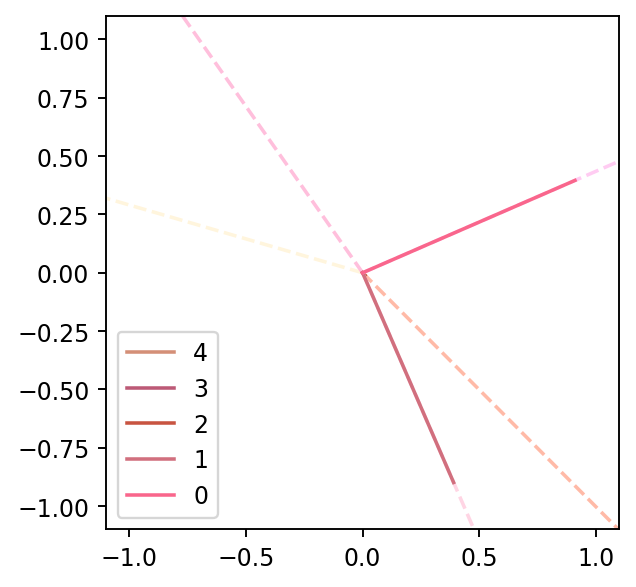

In [9]:
graph_model(w)

## Training 80% Sparsity Model

In [10]:
IMPORTANCE = torch.arange(1, 0, -0.2).to(device)
SPARSITY = 0.80

# NUM_EPOCHS = 20
# BATCHS_PER_EPOCH = 1000
# BATCH_SIZE = 50

model_80_sparsity = ToyModelNoSparsity().to(device)
optimizer = torch.optim.SGD(model_80_sparsity.parameters(), lr=1e-3)
loss_func = ImporanceWeightedMSE()

train(model_80_sparsity, loss_func, optimizer, IMPORTANCE, SPARSITY)

EPHOCH: 1 --> loss: 0.09167324419787044
EPHOCH: 2 --> loss: 0.039027705561369655
EPHOCH: 3 --> loss: 0.027904292999319732
EPHOCH: 4 --> loss: 0.030681899339854716
EPHOCH: 5 --> loss: 0.031198826006539167
EPHOCH: 6 --> loss: 0.031917698742002246
EPHOCH: 7 --> loss: 0.0321742406925559
EPHOCH: 8 --> loss: 0.030695891885496675
EPHOCH: 9 --> loss: 0.028658697376176715
EPHOCH: 10 --> loss: 0.03143403225686401


In [11]:
w = model_80_sparsity.weights.T.to('cpu').detach()
print(w)

tensor([[-0.8685,  0.5146],
        [ 0.8620, -0.5191],
        [ 0.5143,  0.8801],
        [-0.5072, -0.8471],
        [ 0.0027, -0.0011]])


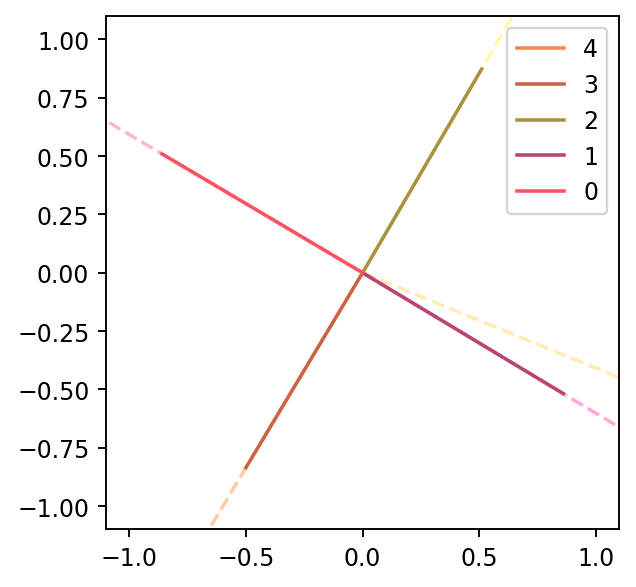

In [12]:
graph_model(w)